<a href="https://colab.research.google.com/github/felixzhao/title_catgories_classification/blob/main/V9_1_implement_a_multi_classes_classification_by_Transfer_learning_based_on_Leverage_pre_trained_model_sentence_transformers_bert_base_nli_mean_tokens_by_pytroch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# fine tuning categories multi-class classification 

In this work, we utilized a transfer learning approach by leveraging a pre-trained model, specifically, BERT-base-NLI-mean-tokens. This model was fine-tuned using our categorical data.

After only three epochs, we observed a clear trend of decreasing values for both training and validation. The average accuracy reached 65%. Increasing the number of epochs is expected to further enhance the model's performance.



# 1. Install necessary libraries:

In [1]:
! pip install torch sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 78.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=b8a050979ad6fe392775fc558b39190f494ce080c22dfd206d9e3cb32e3f9eee
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


# 2. Import required modules:


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sentence_transformers import SentenceTransformer


In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn import metrics
from matplotlib.pylab import plt
from numpy import arange

# 3. load  data

In [4]:
from google.colab import drive
drive.mount('/content/drive')
root_path = "drive/MyDrive/trademe_data/"

Mounted at /content/drive


In [5]:
raw_path = f"{root_path}raw.csv"

In [6]:
raw_df = pd.read_csv(raw_path)
raw_df.head(1)

,Unnamed: 0,x_title,y_cat_id,cat_1,cat_2,cat_3,x_title_feature
0,0,unqualified asbestos remover,5192,trades & services,labourers,labourers,unqualifi asbesto remov


In [7]:
len(raw_df.y_cat_id.unique())

195

In [8]:
raw_df = raw_df[[ 'x_title_feature', 'cat_2']]
print(len(raw_df))
raw_df.head(10)

20000


,x_title_feature,cat_2
0,unqualifi asbesto remov,labourers
1,senior test analyst,testing
2,ict trainer supervisor,tutoring & training
3,automot specialist multi facet posit,technicians
4,busi analyst,business & systems analysts
5,experienc excav oper truck driver,machine operators
6,system account,accountants
7,industri electrician,electrical
8,chef,chefs
9,project architect,architects


In [9]:
from sklearn.preprocessing import LabelEncoder
 
# Creating a instance of label Encoder.
le = LabelEncoder()
 
# Using .fit_transform function to fit label
# encoder and return encoded label
label = LabelEncoder().fit_transform(raw_df['cat_2'])
 
raw_df['y'] = label
# # printing label
# print(len(raw_df.y.unique()))
# raw_df

In [10]:
num_classes = len(raw_df.y.unique())
num_classes

161

In [11]:
raw_df.y.unique()

array([ 86, 150, 155, 145,  21,  90,   1,  54,  28,   9,  85,  14,  89,
        26, 126, 105, 102,  34, 101,   5,  75,  19,  60, 111,  27,  92,
        47,  51, 136, 108, 114, 115,  82,  17, 138,  25, 135, 128,  13,
       120,  18,  76, 140, 112,  87,  98,  53, 141, 124,  58, 131,  78,
        94,  33, 156, 158, 143,  81, 129,  64,  30, 122,  20, 118,  23,
       123, 157, 132,  46,  59,  74, 113,  96,  29,  70,  38,  43,  99,
        91,  88,  49, 127,   2, 107,  11,  97, 146, 134, 117,  50,  57,
        95, 144,   6,  83, 148,  61,  22,  73, 137, 133, 139,  68,  41,
       110, 100, 104, 142,  62,  44, 152,  77,  67,  39, 159, 130,   8,
         7, 119,  80,  63, 103, 147, 125, 149,  93, 151, 106,  52,  79,
        71, 160,  37,  65,  69,   3,  72,   4,   0,  40,  10, 154,  15,
       116,  66,  36,  12,  45,  16,  42, 121,  48,  31, 153,  55,  32,
        24, 109,  84,  35,  56])

In [12]:
len(raw_df)

20000

In [13]:
raw_df = raw_df.dropna()

In [14]:
len(raw_df)

19999

In [15]:
raw_df.head(1)

,x_title_feature,cat_2,y
0,unqualifi asbesto remov,labourers,86


# 3. Create a custom dataset class:

In [20]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, tokenizer, max_length):
        self.data = data
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]
        label = self.labels[idx]

        encoded = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"].flatten(),
            "attention_mask": encoded["attention_mask"].flatten(),
            "label": torch.tensor(label, dtype=torch.long)
        }


# 4. Load the pre-trained model and tokenizer:

In [21]:
model_name = "sentence-transformers/bert-base-nli-mean-tokens"
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)


# 5. Create a custom classification model:

In [22]:
class MulticlassClassifier(nn.Module):
    def __init__(self, bert_model, num_classes):
        super(MulticlassClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(p=0.3)
        self.linear = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(input_ids=input_ids, attention_mask=attention_mask, return_dict=False)
        output = self.dropout(pooled_output)
        return self.linear(output)


# 6. Initialize custom classification model:

In [23]:
model = MulticlassClassifier(bert_model, num_classes)

# 7. Prepare the data:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(raw_df['x_title_feature'], raw_df['y'], test_size=0.2, random_state=123456)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=123456)

In [ ]:
X_train = X_train.to_list()
y_train = y_train.to_list()
X_test = X_test.to_list()
y_test = y_test.to_list()
X_val = X_val.to_list()
y_val = y_val.to_list()

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

12799
4000
3200


In [27]:
max_length = 128
train_dataset = CustomDataset(X_train, y_train, tokenizer, max_length)
val_dataset = CustomDataset(X_val, y_val, tokenizer, max_length)
test_dataset = CustomDataset(X_test, y_test, tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# 8. Set up training configuration:

just run 3 epochs for demo

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

epochs = 3
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()


# 9. Train and evaluate the model:

In [51]:
train_loss = []
val_loss = []

In [52]:
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs, labels)
        total_train_loss += loss.item()
        loss.backward()
        optimizer.step()

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    with torch.no_grad():
        for batch in train_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            total_val_correct += (preds == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = total_val_loss / len(train_loader)
    val_accuracy = total_val_correct / len(train_loader)
    train_loss.append(avg_train_loss)
    val_loss.append(avg_val_loss)
    print(f"Epoch: {epoch+1}/{epochs}, Train Loss: {avg_train_loss: .4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")




Epoch: 1/3, Train Loss:  1.2218, Validation Loss: 0.9373, Validation Accuracy: 12.4663
Epoch: 2/3, Train Loss:  1.0455, Validation Loss: 0.7945, Validation Accuracy: 12.9475
Epoch: 3/3, Train Loss:  0.9129, Validation Loss: 0.6756, Validation Accuracy: 13.3600


In [53]:
train_loss

[1.2217801443114877, 1.045489738881588, 0.9129145820997655]

In [54]:
val_loss

[0.9372900007851421, 0.7945219952985645, 0.6756403385847807]

## 9.1 plot loss

We can observe a clear trend of decreasing values for both training and validation.

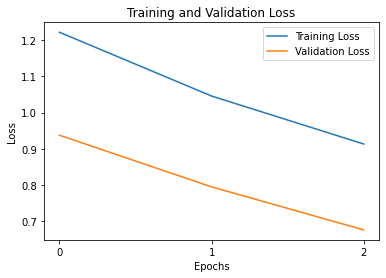

In [69]:
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(0, epochs)

# Plot and label the training and validation loss values
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')

# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Set the tick locations
plt.xticks(arange(0, epochs, 1))

# Display the plot
plt.legend(loc='best')
plt.show()

# 10. Eval model

In [70]:
def predict(test_loader, model, device):
    model.eval()
    y_pred = []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            y_pred.extend(preds.tolist())
    return y_pred

In [71]:
y_pred = predict(test_loader, model, device)

In [72]:
metrics.accuracy_score(y_test, y_pred)

0.65375

In [73]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.89      0.83      0.86        66
           2       0.60      0.40      0.48        15
           3       0.58      0.70      0.64        10
           4       0.00      0.00      0.00         2
           5       0.67      0.79      0.72       169
           6       0.00      0.00      0.00         4
           7       0.71      0.75      0.73        20
           8       0.67      0.22      0.33         9
           9       0.89      0.84      0.86        19
          10       0.00      0.00      0.00         2
          11       0.57      0.60      0.59        20
          12       1.00      0.50      0.67         4
          13       0.71      0.85      0.77        46
          14       0.41      0.74      0.53        34
          15       0.75      0.43      0.55         7
          16       0.00      0.00      0.00         1
          17       0.50    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
